In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import matplotlib
from IPython.display import set_matplotlib_formats
import numba

In [2]:
%matplotlib inline
warnings.simplefilter('ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [9]:
from collections import Counter

# EDA

In [3]:
train = pd.read_csv('train.csv')
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
train.iloc[:1,:].apply(lambda row: (row == 0).sum(), axis = 1)

0    687
dtype: int64

In [31]:
train.shape

(42000, 785)

In [30]:
%%time
for i in range(train.shape[0]):
    Counter(train.values[i])

Wall time: 5.08 s


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [11]:
test = pd.read_csv('test.csv')
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Optimizing memory

In [12]:
def func_memory(value):
    value_mem  = value.memory_usage(deep = True).sum()/1024**2
    return f'{value_mem:03.2f} MB'

In [13]:
print('Train:', func_memory(train))
print('Test:', func_memory(test))

Train: 251.54 MB
Test: 167.48 MB


### Convert DataSet

In [14]:
convert_train = train.apply(pd.to_numeric, downcast = 'unsigned')
convert_test = test.apply(pd.to_numeric, downcast = 'unsigned')

In [15]:
print('convert_train:', func_memory(convert_train))
print('convert_test:', func_memory(convert_test))

convert_train: 31.44 MB
convert_test: 20.94 MB


In [16]:
print('train:',convert_train.shape)
print('test:',convert_test.shape )

train: (42000, 785)
test: (28000, 784)


In [17]:
count_number = convert_train.groupby('label').agg({'pixel0':'count'}).rename(columns = {'pixel0':'CountNumber'}).reset_index()

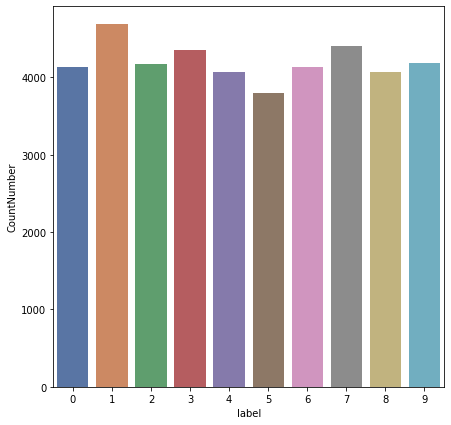

In [18]:
fig, (ax1) = plt.subplots(figsize = (7,7))
sns.barplot(x=count_number['label'], y = count_number['CountNumber'], palette="deep", ax = ax1)
plt.show()

## I want to see some numbers

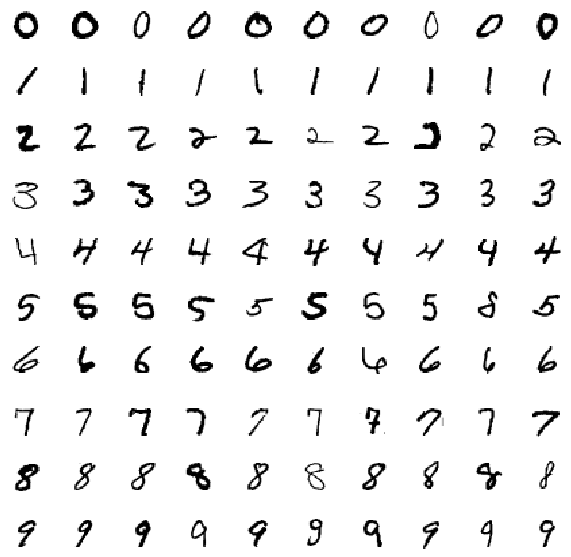

In [19]:
fig, ax  = plt.subplots(10,10, gridspec_kw = {'hspace' : 0.5, 'wspace': 0.5}, figsize = (10,10))

for i in range(10):
    _ = convert_train.loc[convert_train['label'] == i]
    number_img  = (_.iloc[:,1:].values).astype('float32')
    for j in range(10):
        some_number_img = number_img[j].reshape(28,28)
        ax[i,j].imshow(some_number_img, cmap = matplotlib.cm.binary)
        ax[i,j].axis('off')

# Train test split and cross_ vall_score

In [20]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, precision_recall_curve, roc_curve
from sklearn.preprocessing import MinMaxScaler

In [21]:
X = convert_train.drop('label', axis = 1)
y = convert_train[['label']]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [98]:

def score_model(model, X_train, y_train, X_test, y_test):
    

    model.fit(X_train, y_train)
    score_train = model.score(X_train,y_train)
    score_test = model.score(X_test, y_test)
    
    cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
    mean_cross_val_score = cross_val_score(model, X_train, y_train, cv = cv)
    
    return [score_train,score_test,mean_cross_val_score.mean()]

### SVC

In [4]:
from sklearn.svm import SVC

In [5]:
clf_svc  = SVC()

In [20]:
score_scv = score_model(clf_svc, X_train, y_train, X_test, y_test)

In [21]:
print(f'score_train: {np.round(score_scv[0] *100,2)} %')
print(f'score_test: {np.round(score_scv[1] *100,2)} %')
print(f'mean_cross_val_score: {np.round(score_scv[2] *100,2)} %')

score_train: 98.79 %
score_test: 97.4 %
mean_cross_val_score: 97.14 %


### Confusion matrix for all numbers

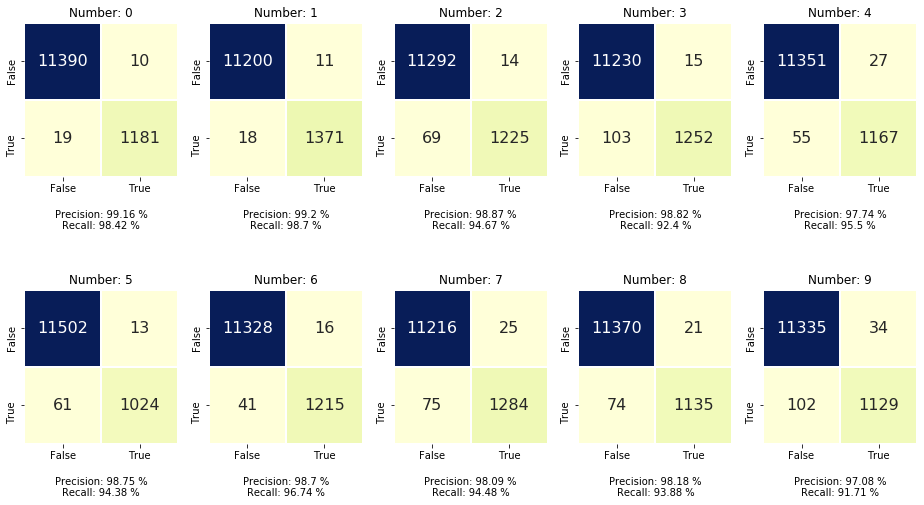

In [22]:
i = 0
j = 0
fig, ax = plt.subplots(2,5, figsize =(16,9) )
for num in range(10):
    y_train_num = (y_train == num)
    y_test_num = (y_test == num)
    
    clf_svc.fit(X_train,y_train_num)
    y_pred_num = clf_svc.predict(X_test)
    
    matrix = confusion_matrix(y_test_num, y_pred_num)
    
    if num == 5:
        i = 1
        j= 0
        
    sns.heatmap(matrix,annot=True,cmap='YlGnBu',
                                                fmt='d',
                                                linewidths=1,
                                                xticklabels = ['False','True'],
                                                yticklabels = ['False','True'],
                                                square = True,
                                                annot_kws={'size':16},
                                                cbar = False,
                                                ax  = ax[i,j])
    
    ax[i,j].set_xlabel(f'\nPrecision: {np.round(precision_score(y_test_num, y_pred_num) *100,2)} %\nRecall: {np.round(recall_score(y_test_num, y_pred_num) *100,2)} %')
    ax[i,j].set_title(f'Number: {num}')
    
    j+=1
plt.show()

In [23]:
y_pred_cross_val = cross_val_predict(clf_svc, X_train, y_train['label'], cv = 5)

In [24]:
conf_mx = confusion_matrix(y_train, y_pred_cross_val)

In [25]:
conf_mx

array([[2897,    0,    4,    1,    3,    9,    7,    1,    9,    1],
       [   0, 3253,   11,    5,    7,    1,    2,    6,    7,    3],
       [   7,    3, 2807,    5,   11,    5,    8,   18,   13,    6],
       [   2,    7,   33, 2868,    1,   38,    2,   11,   23,   11],
       [   3,    8,    7,    0, 2774,    0,    6,    2,    3,   47],
       [  11,    3,    2,   31,    8, 2625,   16,    2,   10,    2],
       [  18,    2,    1,    0,    5,   18, 2835,    0,    2,    0],
       [   6,   14,   20,    3,   11,    1,    0, 2953,    4,   30],
       [   6,   13,    9,   19,   12,   13,    9,    5, 2752,   16],
       [   7,    6,    3,   25,   49,   10,    0,   33,   17, 2807]],
      dtype=int64)

In [26]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx/row_sums
np.fill_diagonal(norm_conf_mx, 0)

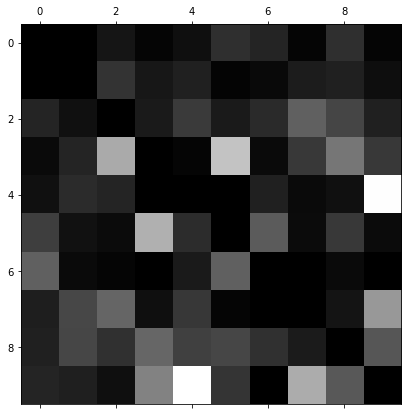

In [27]:
fig, (ax1) = plt.subplots(figsize = (7,7))
ax1.matshow(norm_conf_mx, cmap = plt.cm.gray, )
plt.show()

9 is similar to 4

and

5 is similar to 3

# Final

In [22]:
clf_svc.fit(X,y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [23]:
y_pred = clf_svc.predict(test)

In [29]:
submit = pd.Series(data = y_pred, index = test.index , name = 'label').to_frame().reset_index()

In [32]:
submit = submit.rename(columns = {'index':'ImageId'})

In [35]:
submit['ImageId'] = submit['ImageId']+1

In [37]:
submit.to_csv('submit_numbers',index = False)

In [38]:
submit

,ImageId,label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
